1. Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import warnings
import re
from datetime import datetime
# warnings.filterwarnings('ignore')


#### 1.0 Funciones útiles

In [2]:
def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15, pref="", title=""):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  count_values.index = count_values.index.astype('str') + pref
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=title)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])

from IPython.display import display, Markdown

def resumen(data, nombre_tabla="Resumen Tabla"):
    filas, columnas = data.shape
    valores = filas * columnas
    nulos, duplicados =  data.isna().values.sum(), data.duplicated().sum()
    tasa_nulos, tasa_duplicados = nulos / valores, duplicados / valores

    salida = f'''<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>{nombre_tabla}</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> {filas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> {columnas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> {valores} </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> {nulos} </td><td style='text-align: right'> {round(100*tasa_nulos, 2)} % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> {duplicados} </td><td style='text-align: right'> {round(100*tasa_duplicados, 2)} %</td><tr/>
    </tbody>
    </table>'''

    display(Markdown(salida))

def ver_nulos_x_fila(data):
  ax = sns.barplot(x=nulos_filas(data).cant_col_nulas, y=nulos_filas(data).cantidad)
  for i in ax.containers:
      ax.bar_label(i,)
  plt.title("cantidad nulos x fila")
  plt.show()

def ver_nulos_x_columna(data):
  nulos_columnas = data.isna().sum()[data.isna().sum() > 0].sort_values(ascending=False)
  # ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
  if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
    for i in ax.containers:
      ax.bar_label(i,)

## 1.1 Extracción, Transformación y Carga de Datos (ETL)

### 1.1.1 Extracción

In [3]:

# Datos Homicidios Hechos
data_hm = pd.read_excel('data/homicidios.xlsx', sheet_name='HECHOS')

# Datos Homicidios Victimas
data_vm = pd.read_excel('data/homicidios.xlsx', sheet_name='VICTIMAS')
# Datos Lesiones Hechos
# data_hl = pd.read_excel('data/lesiones.xlsx', sheet_name='HECHOS')
data_hl = pd.read_csv('data/generated/data_hl.csv')
# Datos Lesiones Victimas
# data_vl = pd.read_excel('data/lesiones.xlsx', sheet_name='VICTIMAS')
data_vl = pd.read_csv('data/generated/data_vl.csv')

# https://www.indec.gob.ar/ftp/cuadros/poblacion/cnphv2022_resultados_provisionales.pdf Página 8
data_pob_comunas = pd.read_excel('data/cnphv2022_resultados_provisionales.xlsx', sheet_name='Table 2').query("Comuna != 'Total'").iloc[:,[3]]

# Barrios
df_barrios = pd.read_excel('data/barrios.xlsx')
# Comunas
df_comunas = pd.read_excel('data/comunas.xlsx')

In [4]:
# data_hl.to_csv('data/generated/data_hl.csv')
# data_vl.to_csv('data/generated/data_vl.csv')

### 1.1.2 Transformación

### 1.1.2.1 Dataset Homicidios

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [5]:
resumen(data_hm)

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Resumen Tabla</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 696 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 21 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 14616 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 747 </td><td style='text-align: right'> 5.11 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 0 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

#### 1.1.2.1.1 Análisis de Nulos

##### a. Por filas

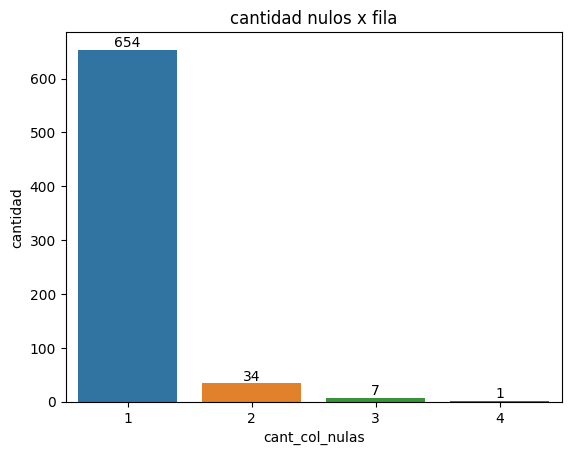

In [6]:
ver_nulos_x_fila(data_hm)

Significa que hay 654 filas que tienen una columna nula, 34 filas con 2 columnas nulas. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

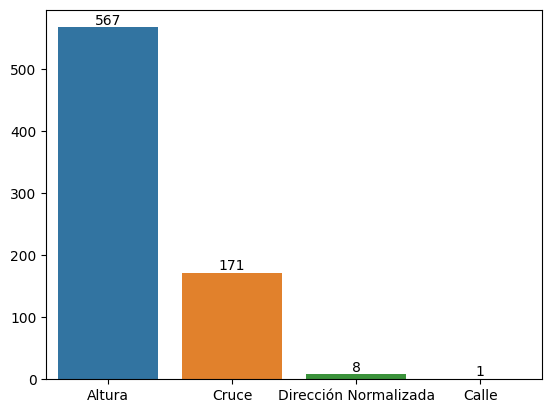

In [7]:
ver_nulos_x_columna(data_hm)

In [8]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hm.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hm.isna().T.sum()>0)}")

Cantidad filas: 696
Cantidad filas al menos un nulo: 696


Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

Después de hacer un oversight sobre el dataset, vemos que Altura y Cruce son excluyentes, cuando está definida la altura es porque es sobre una calle propia y en caso contrario es una esquina. Por lo tanto, vamos a excluirlas del análisis de nulos.

In [9]:
# La columna altura se llena con ESQ cuando es esquina
# data_hm.Altura = data_hm.Altura.fillna('ESQ')
data_hm.fillna({'Altura': "ESQ"}, inplace = True)

# Se limpia el valor altura cuando lo toma como decimal
data_hm.Altura = data_hm.Altura.apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))

In [10]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hm.fillna({'Cruce': "NA"}, inplace = True)

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

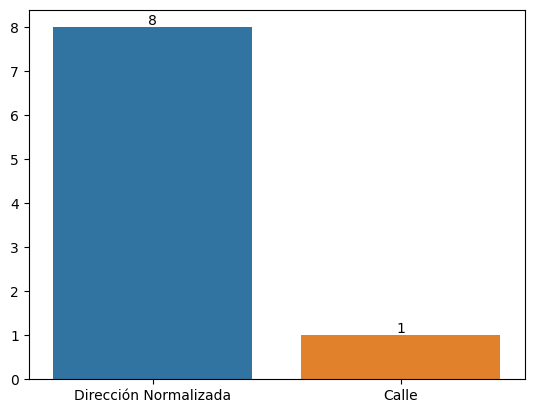

In [11]:
ver_nulos_x_columna(data_hm)

Columna ```Dirección Normalizada```

In [12]:
data_hm[data_hm.isna().loc[:, 'Dirección Normalizada']].head(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,...,ESQ,NA,NaN,13,Point (. .),.,.,MOTO-SD,MOTO,SD
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,...,ESQ,NA,NaN,4,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Rellenamos la información faltante en la columna ```Dirección Normalizada``` con los valores de ```LUGAR_DEL_HECHO```

In [13]:
nulos = [idx for idx, _ in enumerate(data_hm['Dirección Normalizada'].isna())]
for i in nulos:
    data_hm.loc[i, 'Dirección Normalizada'] = data_hm.loc[i, 'LUGAR_DEL_HECHO']

Columna ```Calle```

In [14]:
data_hm[data_hm.isna().loc[:, 'Calle']].T

,119
ID,2016-0151
N_VICTIMAS,1
FECHA,2016-11-18 00:00:00
AAAA,2016
MM,11
DD,18
HORA,20:35:00
HH,20
LUGAR_DEL_HECHO,SD
TIPO_DE_CALLE,CALLE


No tenemos información suficiente en el registro ```2016-0151```. No tenemos información geográfica, estos registros podemos diferenciarlos posteriormente para saber en qué análisis los incluimos y en cuáles no.

In [15]:
data_hm[data_hm.loc[:, 'Calle'].isna()].fillna({'Calle': 'SD'}, inplace=True)

C:\Users\javier\AppData\Local\Temp\ipykernel_27428\94753469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hm[data_hm.loc[:, 'Calle'].isna()].fillna({'Calle': 'SD'}, inplace=True)


Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

Columnas <code>"pos x"</code> y <code>"pos y"</code>

Marcamos las filas que no tienen valores geográficos.

In [16]:
data_hm['data_geo'] = True

limpiar_coord = lambda x: 0 if x == '.' else float(x)
data_hm['pos x'] = data_hm['pos x'].apply(limpiar_coord)
data_hm['pos y'] = data_hm['pos y'].apply(limpiar_coord)

for i in data_hm.index:
    if data_hm.loc[i, 'pos x'] == 0:
        data_hm.loc[i, 'data_geo'] = False
    if data_hm.loc[i, 'pos y'] == 0:
        data_hm.loc[i, 'data_geo'] = False

data_hm['data_geo'].value_counts()        

data_geo
True     684
False     12
Name: count, dtype: int64

Columna <code>COMUNA</code>

In [17]:
data_hm.loc[:, 'COMUNA'] = data_hm.loc[:, 'COMUNA'].astype(str);

C:\Users\javier\AppData\Local\Temp\ipykernel_27428\2246488346.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['8' '9' '1' '8' '1' '8' '11' '9' '1' '1' '15' '4' '8' '9' '1' '7' '1' '8'
 '12' '7' '1' '12' '8' '4' '3' '4' '7' '8' '3' '7' '8' '7' '13' '1' '15'
 '4' '8' '4' '13' '12' '8' '14' '14' '1' '1' '10' '6' '8' '2' '3' '10' '8'
 '8' '15' '1' '3' '13' '9' '12' '4' '6' '1' '4' '10' '1' '12' '13' '5'
 '13' '6' '11' '8' '1' '3' '11' '12' '9' '9' '9' '15' '1' '4' '9' '9' '15'
 '1' '9' '14' '12' '8' '14' '1' '12' '9' '7' '7' '10' '10' '8' '5' '1' '4'
 '3' '14' '8' '14' '4' '11' '13' '14' '13' '1' '8' '4' '13' '4' '1' '15'
 '4' '0' '7' '15' '8' '10' '3' '11' '8' '9' '14' '15' '11' '4' '4' '4'
 '12' '12' '1' '5' '7' '0' '7' '1' '14' '3' '11' '4' '1' '14' '5' '6' '12'
 '4' '4' '12' '2' '1' '14' '9' '1' '7' '7' '4' '1' '6' '9' '9' '3' '8'
 '11' '14' '1' '12' '1' '7' '13' '7' '14' '10' '8' '8' '9' '7' '8' '4'
 '15' '12

In [18]:
data_hm.query("COMUNA == '0'")

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,NA,SD,0,Point (. .),0.0,0.0,PEATON-SD,PEATON,SD,False
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,...,NA,AUTOPISTA 25 DE MAYO,0,Point (. .),0.0,0.0,SD-SD,SD,SD,False


Vemos que la marca <code>data_geo</code> está en <code>Falso</code> por lo tanto, estos registros que no tienen <code>Comuna</code> definida, no se registrarán para análisis geográficos.

In [19]:
data_hm[data_hm.loc[:, 'Dirección Normalizada'] == 'SD']

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,NA,SD,0,Point (. .),0.0,0.0,PEATON-SD,PEATON,SD,False


Mismo caso que el anterior, para excluir de los análisis geográficos.

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [20]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

Columna <code>Hora</code>

In [21]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo
518,2019-0103,1,2019-12-18,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",ESQ,GRIVEO,"PAZ, GRAL. AV. Y GRIVEO",11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,True


In [22]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')
data_hm["HORA"] = data_hm["HORA"].astype(str)
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)
data_hm['HORA'] = data_hm['HORA'].astype(str)

Creación de la columna <code>FECHA_HORA</code> a partir de las columnas de fecha y hora.

In [23]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))
data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

def to_date(t):
    return datetime(* t)

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(to_date)



In [ ]:
data_hm.query("Calle.isna()")
data_jm.fillna({'Calle': 'SD'}, inplace=True)

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo,FECHA_HORA
119,2016-0151,1,2016-11-18,20:35:00,SD,CALLE,NaN,ESQ,NA,SD,0,0.0,0.0,PEATON-SD,PEATON,SD,False,2016-11-18 20:35:00


In [ ]:
data_hm['FECHA_HORA']

0     2016-01-01 04:00:00
1     2016-01-02 01:15:00
2     2016-01-03 07:00:00
3     2016-01-10 00:00:00
4     2016-01-21 05:20:00
              ...        
691   2021-12-13 17:10:00
692   2021-12-20 01:10:00
693   2021-12-30 00:43:00
694   2021-12-15 10:30:00
695   2021-11-18 06:10:00
Name: FECHA_HORA, Length: 696, dtype: datetime64[ns]

In [ ]:
# import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [ ]:
data_hm[data_hm['data_geo']]['pos x'].mean()

-58.441545233561044

In [ ]:
data_hm[data_hm['data_geo']]['pos y'].mean()

-34.61963157034327

In [ ]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'NA'

In [ ]:
data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,data_geo,FECHA_HORA
ID,,,,,,,,,,,,,,,,,
2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.",AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00
2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,AV GRAL PAZ Y AV DE LOS CORRALES,9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00
2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,NA,AV ENTRE RIOS 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00
2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.",AV LARRAZABAL Y GRAL VILLEGAS CONRADO,8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00
2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.",AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,AV. RIESTRA Y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00
2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,AU DELLEPIANE Y LACARRA,9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00
2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,AV. GAONA Y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00


In [ ]:
# data_hm = data_hm.drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [ ]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

In [ ]:
data_hm

,id,n_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,data_geo,fecha_hora
0,2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.",AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00
1,2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,AV GRAL PAZ Y AV DE LOS CORRALES,9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00
2,2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,NA,AV ENTRE RIOS 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00
3,2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.",AV LARRAZABAL Y GRAL VILLEGAS CONRADO,8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00
4,2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.",AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,AV. RIESTRA Y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00
692,2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,AU DELLEPIANE Y LACARRA,9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00
693,2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,AV. GAONA Y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00
694,2021-0096,1,2021-12-15,10:30:00,AV. EVA PERON 4071,AVENIDA,"PERON, EVA AV.",4071,NA,AV. EVA PERON 4071,9,-58.470668,-34.650217,AUTO-CARGAS,AUTO,CARGAS,True,2021-12-15 10:30:00


In [ ]:


df_comunas['barrios'] = df_comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
df_comunas.set_index('COMUNAS', drop=True, inplace=True)
df_comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
df_comunas.sort_index()

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
1,LIMITE COMUNAL,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,"[CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI..."
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
3,LIMITE COMUNAL,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,"[BALVANERA, SAN CRISTOBAL]"
4,LIMITE COMUNAL,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,35423.282799,2.168464e+07,"[BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]"
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
8,LIMITE COMUNAL,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,"[VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"


In [ ]:
pd.merge(pd.DataFrame(df_comunas.barrios.explode()).reset_index(names='comuna_id'), df_comunas, left_on='comuna_id', right_on='COMUNAS')

,comuna_id,barrios_x,OBJETO,BARRIOS,PERIMETRO,AREA,barrios_y
0,2,RECOLETA,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
1,5,ALMAGRO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
2,5,BOEDO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
3,6,CABALLITO,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
4,7,FLORES,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
5,7,PARQUE CHACABUCO,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
6,9,LINIERS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
7,9,MATADEROS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
8,9,PARQUE AVELLANEDA,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
9,10,FLORESTA,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."


In [ ]:
barrio_comuna = pd.DataFrame(df_comunas.barrios.explode())

In [ ]:
barrio_comuna

,barrios
COMUNAS,
2,RECOLETA
5,ALMAGRO
5,BOEDO
6,CABALLITO
7,FLORES
7,PARQUE CHACABUCO
9,LINIERS
9,MATADEROS
9,PARQUE AVELLANEDA


In [ ]:
# barrios.BARRIO.

In [ ]:
# import pandas as pd
# import researchpy as rp

# # Assuming df is your DataFrame containing the categorical variables
# # Let's say 'var1' and 'var2' are the columns representing the categorical variables

# data = data.reset_index()

# # Create a contingency table (cross-tabulation)
# contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# # Calculate Cramér's V
# cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
#                                 prop= 'cell', 
#                                 test= 'chi-square', 
#                                 expected_freqs= True, 
                                
#                                 correction= False)['results']

# cramers_v = cramers_v_result.loc[2, 'results']

# print("Cramér's V:", cramers_v)


In [ ]:
pd.crosstab(data_hm['VICTIMA'], data_hm['ACUSADO'])


ACUSADO,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
VICTIMA,,,,,,,,,,
AUTO,31,0,14,0,3,21,1,9,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,83,2,78,25,8,40,4,46,9,0
MOVIL,0,0,1,0,0,0,0,1,0,0
OBJETO FIJO,1,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,77,5,38,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,1,0,0,0,0,0,0


In [ ]:
pd.crosstab(data_hm['PARTICIPANTES'], data_hm['ES_CRUCE']).sum()

ES_CRUCE
False    169
True     525
dtype: int64

In [ ]:
data_hm = data_hm.set_index(data_hm['ID']).drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [ ]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

# plt.plot(data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum())

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


In [ ]:
data_hm['comuna'][data_hm['comuna'].isnull()]

Series([], Name: comuna, dtype: object)

In [ ]:
data_hm['comuna'] = data_hm['comuna'].apply(lambda x: int(x))

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


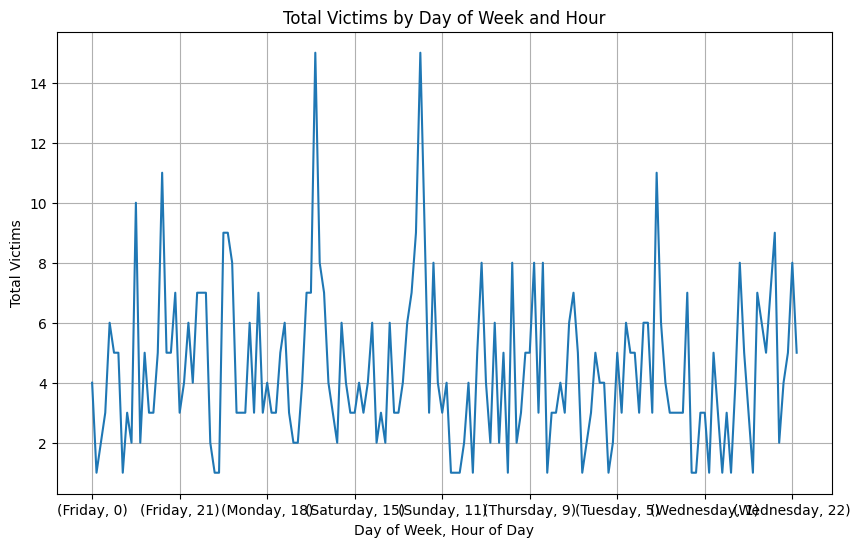

In [ ]:
import matplotlib.pyplot as plt

# Assuming data_hm['fecha_hora'] is already a datetime column in data_hm

# Group by day name and hour, then sum 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum()

# Plot the result
grouped_data.plot(kind='line', figsize=(10, 6))
plt.xlabel('Day of Week, Hour of Day')
plt.ylabel('Total Victims')
plt.title('Total Victims by Day of Week and Hour')
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hour_of_Day', y='n_victimas', color='Day_of_Week', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Day_of_Week': 'Day of Week', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Iterate over unique days and create a separate bar plot for each day
for day in grouped_data['Day_of_Week'].unique():
    # Filter data for the current day
    day_data = grouped_data[grouped_data['Day_of_Week'] == day]
    
    # Create a bar plot for the current day
    fig = px.bar(day_data, x='Hour_of_Day', y='n_victimas', 
                 title=f'Total Number of Victims by Hour on {day}',
                 labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'})
    
    # Show the plot
    fig.show()


In [ ]:
data_hm['es_cruce'] = data_hm['es_cruce'].map({False:'Calle', True:'Esquina'})

In [ ]:
import plotly.express as px

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a pie chart using Plotly Express
fig = px.pie(grouped_data, values='n_victimas', names='es_cruce', 
             title='Proportion of Victims by Crossing Status')

# Show the plot
fig.show()

In [ ]:
data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()['es_cruce'].map({False:"Calle", True:"Esquina"})

0    NaN
1    NaN
Name: es_cruce, dtype: object

In [ ]:
import pandas as pd

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a mapping dictionary
mapping = {False: "Calle", True: "Esquina"}

# Map boolean values to corresponding labels
grouped_data['es_cruce'] = grouped_data['es_cruce'].map(mapping)

# Show the result
print(grouped_data)

  es_cruce  n_victimas
0      NaN         175
1      NaN         540


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                 data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Año', y='n_victimas', color='Mes',
             title='Total Number of Victims by Day of Year and Month',)
            #  labels={'Año': 'Day of Week', 'n_victimas': 'Total Victims'},
            #  category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()

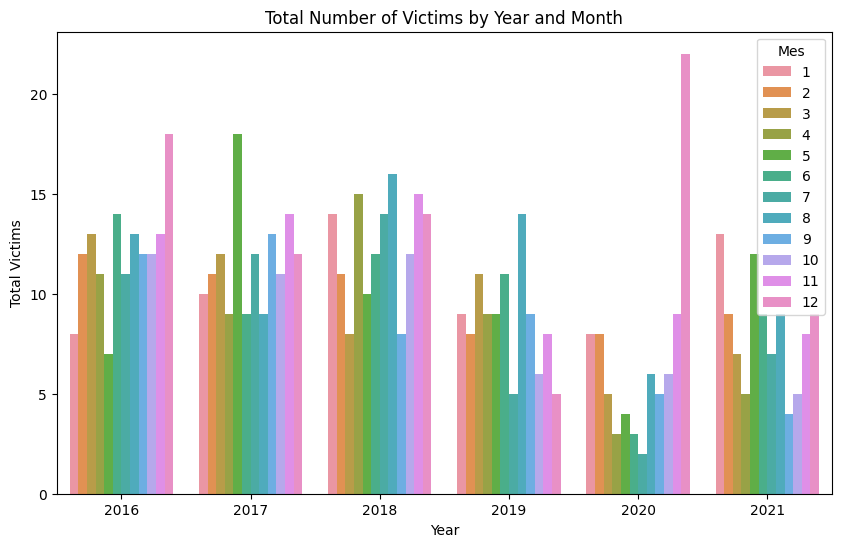

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and month, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Total Number of Victims by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Victims')

# Show the plot
plt.show()


In [ ]:
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

grouped_data

,Año,Mes,n_victimas
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [ ]:
data_hm.groupby(data_hm['fecha_hora'].dt.to_period('M'))['n_victimas'].sum()

fecha_hora
2016-01     8
2016-02    12
2016-03    13
2016-04    11
2016-05     7
           ..
2021-08     9
2021-09     4
2021-10     5
2021-11     8
2021-12     9
Freq: M, Name: n_victimas, Length: 72, dtype: int64

In [ ]:
data_hm['fecha_hora'].dt.to_period('M')

ID
2016-0001    2016-01
2016-0002    2016-01
2016-0003    2016-01
2016-0004    2016-01
2016-0005    2016-01
              ...   
2021-0093    2021-12
2021-0094    2021-12
2021-0095    2021-12
2021-0096    2021-12
2021-0097    2021-11
Name: fecha_hora, Length: 694, dtype: period[M]

In [ ]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = data_hm.groupby(data_hm['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total Number of Victims Over Time',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()


In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx')

In [ ]:
data_hm.pos_y.mean()

-34.12078961688012

In [ ]:
import folium
from branca.colormap import LinearColormap

# Assuming data contains latitude, longitude, and the value you want to use for color
# Replace 'value_column' with the actual name of the column in your DataFrame
value_column = 'comuna'

data_hm[value_column] = pd.to_numeric(data_hm[value_column], errors='coerce')

data_hm = data_hm.dropna()
data_hm = data_hm.rename({'pos_x': 'lon',  'pos_y': 'lat'}, axis=1)

# Define the minimum and maximum values for the color scale
min_value = data_hm[value_column].astype(float).min()
max_value = data_hm[value_column].astype(float).max()

# Create a color gradient
colormap = LinearColormap(['blue', 'yellow', 'red'], vmin=min_value, vmax=max_value)

# Create a Folium Map
map = folium.Map()

# Iterate over DataFrame rows
for i, row in data_hm.iterrows():
    # Get latitude, longitude, and value
    lat = row['lat']
    lon = row['lon']
    value = row[value_column]
    
    # Get marker color based on the value
    color = colormap(value)
    
    # Create marker with the specified color
    folium.Marker(location=(lat, lon), icon=folium.Icon(color=color)).add_to(map)

# Display the map
# map

C:\Users\javier\AppData\Local\Temp\ipykernel_23884\3165298995.py:34: UserWarning:

color argument of Icon should be one of: {'black', 'lightgray', 'lightgreen', 'darkred', 'blue', 'red', 'green', 'lightblue', 'orange', 'cadetblue', 'purple', 'gray', 'beige', 'darkpurple', 'darkblue', 'white', 'lightred', 'pink', 'darkgreen'}.



In [ ]:
import csv

data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

In [ ]:
data = pd.read_csv('data/generated/data_hm.csv', sep=';', encoding='utf-8')

In [ ]:
data.iloc[136]

ID                                         2016-0172
n_victimas                                         1
tipo_de_calle                                AVENIDA
calle                             GARAY, JUAN DE AV.
altura                                           ESQ
cruce                                         CASTRO
dirección_normalizada    GARAY, JUAN DE AV. y CASTRO
comuna                                             5
lon                                       -58.419189
lat                                       -34.631743
participantes                            MOTO-CARGAS
victima                                         MOTO
acusado                                       CARGAS
geo_info                                        True
fecha_hora                       2016-12-26 08:00:00
es_cruce                                     Esquina
Name: 136, dtype: object

In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx', engine='openpyxl')

In [ ]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 2016-0001 to 2021-0097
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   n_victimas             694 non-null    int64         
 1   tipo_de_calle          694 non-null    object        
 2   calle                  694 non-null    object        
 3   altura                 694 non-null    object        
 4   cruce                  694 non-null    object        
 5   dirección_normalizada  694 non-null    object        
 6   comuna                 694 non-null    int64         
 7   lon                    694 non-null    float64       
 8   lat                    694 non-null    float64       
 9   participantes          694 non-null    object        
 10  victima                694 non-null    object        
 11  acusado                694 non-null    object        
 12  geo_info               694 non-null    bool          
 

In [ ]:
data_dias = data_hm.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias})

In [ ]:
data_dias = data.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

,fecha_hora,n_victimas
0,0,103
1,1,96
2,2,97
3,3,94
4,4,95
5,5,102
6,6,97


In [ ]:
data_dias = data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias},
             orientation='h')

fig.show()

In [ ]:
data.query('fecha_hora.dt.month == 12 and fecha_hora.dt.year == 2020').n_victimas.sum()

22

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

datos = data.groupby([data['fecha_hora'].dt.year, data['fecha_hora'].dt.month//6 + 1, data['fecha_hora'].dt.month])['n_victimas'].sum()

datos = datos.rename_axis(['Year', 'Semester', 'Month'])

datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Month' as a string
datos['date'] = datos['Year'].astype(str) + '-' + datos['Month'].astype(str).str.zfill(2)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Month and Year',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'},
             color='n_victimas')

# Show the plot
fig.show()

# datos.head(50)

In [ ]:
datos = data.groupby([data['fecha_hora'].dt.year, (data['fecha_hora'].dt.month - 1) // 6 + 1])['n_victimas'].sum()

# Rename the MultiIndex
datos = datos.rename_axis(['Year', 'Semester'])

# Reset the index
datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Semester' as a string
datos['date'] = datos['Year'].astype(str) + '-Semester ' + datos['Semester'].astype(str)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Year and Semester',
             color='n_victimas',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,lon,lat,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,Esquina
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,Esquina
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,Calle
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,Esquina
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,Esquina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,Esquina
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,Esquina
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,Esquina


### 1.1.2.2 Dataset Lesiones

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [ ]:
import pandas as pd
import numpy as np

columnas_usar = ['id', 'n_victimas', 'fecha', 'hora',
       'direccion_normalizada', 'comuna', 'tipo_calle',
       'otra_direccion', 'calle', 'altura', 'cruce', 
       'longitud', 'latutid', 'victima', 'acusado', 'participantes', 'moto',
       'auto', 'transporte_publico', 'camion', 'ciclista', 'gravedad']

data_hl = pd.read_csv('data/generated/data_hl.csv', usecols=columnas_usar, index_col='id')

data_hl.rename({'latutid': 'latitud'}, axis=1, inplace=True)

In [ ]:
data_hl.loc[:,'gravedad'] = data_hl.loc[:,'gravedad'].apply(lambda st: str(st).upper())
data_hl.loc[:,'gravedad'].value_counts()

data_hl.loc[:,'gravedad']=data_hl.loc[:,'gravedad'].replace('SD', 'NO_GRAVE');

data_hl.loc[:, 'gravedad'].value_counts()

# data_hl.loc[:, 'grave'] = data_hl.loc[:, 'grave'].apply(lambda st: False if pd.isna(st) else True)

gravedad
NO_GRAVE    23139
GRAVE         643
FATAL           3
Name: count, dtype: int64

Limpieza de nulos geográficos

In [ ]:
# data_hl.loc[:,'direccion_normalizada'] = data_hl.loc[:,'direccion_normalizada'].replace('SD', np.nan)

pd.set_option('future.no_silent_downcasting', True)
data_hl = data_hl.replace('SD', np.nan)

len(data_hl.query("direccion_normalizada.isna()"))
data_hl.fillna({'cruce': ''}, inplace=True)

data_hl['altura'] = data_hl['altura'].apply(lambda x: int(x) if not pd.isna(x) else 0)

mask = data_hl['direccion_normalizada'].isna()
data_hl.loc[mask, 'direccion_normalizada'] = data_hl.loc[mask, 'otra_direccion']
data_hl['direccion_normalizada'] = data_hl['direccion_normalizada'].str.extract(r'(.+?)(?=, Barrio:|$)', expand=False)

indices = data_hl.query("direccion_normalizada.isna() and calle.notna()")[['direccion_normalizada', 'otra_direccion', 'comuna', 'calle', 'altura', 'cruce']].index
data_hl.altura = data_hl.altura.astype(str)


for i in list(indices):
    if not data_hl.loc[i, 'altura'] in [0, 'nan']:
        data_hl.loc[i, 'direccion_normalizada'] = data_hl.loc[i, 'calle'] + ' ' + data_hl.loc[i, 'altura']
    else:
        data_hl.loc[i, 'direccion_normalizada'] = data_hl.loc[i, 'calle'] + ' y ' + data_hl.loc[i, 'cruce']
        
data_hl['data_geo'] = ~ (data_hl['direccion_normalizada'].isna() & 
                        data_hl['otra_direccion'].isna() & 
                        data_hl['latitud'].isna() & 
                        data_hl['cruce'].notna())



In [ ]:
resumen(data_hl, "Lesiones")

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Lesiones</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 23785 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 22 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 523270 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 132992 </td><td style='text-align: right'> 25.42 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 22 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

In [ ]:
data_hl.drop_duplicates(inplace=True)

#### 1.1.2.2.1 Análisis de Nulos

##### a. Por filas

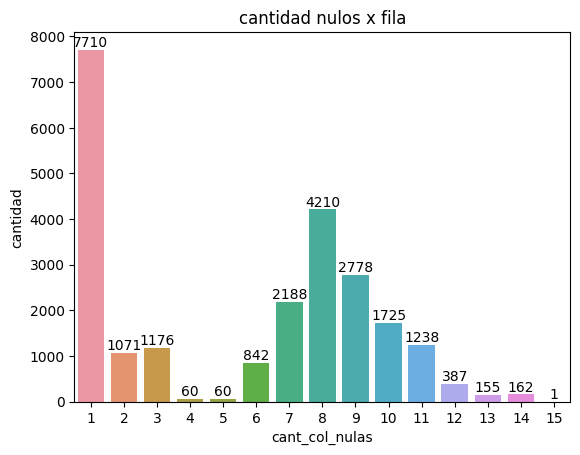

In [ ]:
ver_nulos_x_fila(data_hl)

Significa que hay 287 filas que tienen una columna nula, 7437 filas con 2 columnas nula. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

Separamos un subset para trabajar después

In [ ]:
try:
    data_adicional = data_hl.loc[:,['moto', 'auto', 'transporte_publico', 'camion', 'ciclista']]

    data_adicional.loc[:, 'involucrado'] = data_adicional.eq('x').idxmax(axis=1).str.upper()
    data_adicional.loc[:, 'involucrado'] = data_adicional['involucrado'].apply(lambda x: 'SD' if x == 'ID' else x)
except:
    print("posiblemente operación ya realizada!!!")

In [ ]:
data_hl = data_hl[data_hl.columns[~data_hl.columns.isin(data_adicional.columns)]]
# data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [ ]:
len(data_adicional)

23763

Dividimos el dataset en 2 para trabajar mejor con los gráficos

In [ ]:
# data_1 = data_hl.iloc[:, :int(data_hl.shape[1]/2)]

# data_2 = data_hl.iloc[:,int(data_hl.shape[1]/2)+1:]

In [ ]:
data_hl.columns

Index(['n_victimas', 'fecha', 'hora', 'direccion_normalizada', 'comuna',
       'tipo_calle', 'otra_direccion', 'calle', 'altura', 'cruce', 'longitud',
       'latitud', 'victima', 'acusado', 'participantes', 'gravedad',
       'data_geo'],
      dtype='object')

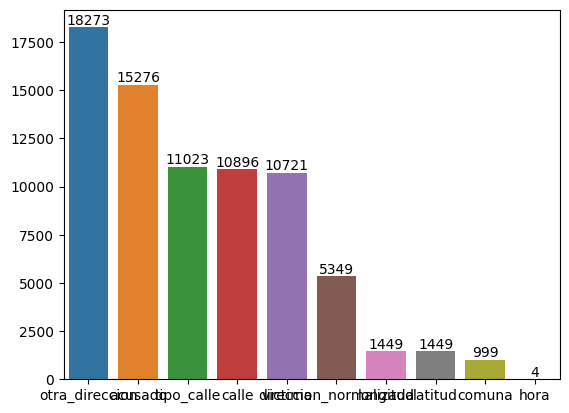

In [ ]:
ver_nulos_x_columna(data_hl)

In [ ]:
# nulos_columnas = data_2.isna().sum()[data_2.isna().sum() > 0].sort_values(ascending=False)
# ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
# for i in ax.containers:
#     ax.bar_label(i,)

In [ ]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hl.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hl.isna().T.sum()>0)}")

Cantidad filas: 23763
Cantidad filas al menos un nulo: 23763


Debido a la gran cantidad de nulos, y viendo un panorama del dataset, vamos a hacer un recorte de las columnas más útiles a criterio del analista

In [ ]:
# columnas_conservar = ['id', 'n_victimas', 'fecha', 'hora','direccion_normalizada', 'comuna','tipo_calle','otra_direccion','calle','altura','cruce','longitud', 'latutid', 'victima', 'gravedad']

In [ ]:
# data_hl = data_hl[columnas_conservar]

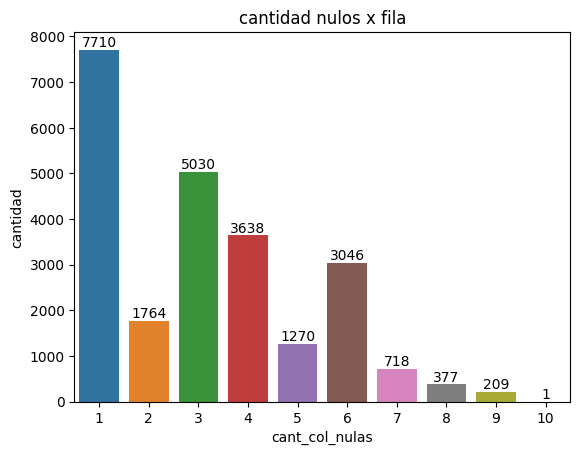

In [ ]:
ver_nulos_x_fila(data_hl)

In [ ]:
data_hl = pd.merge(data_hl,data_adicional, on='id')

In [ ]:
data_hl

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,otra_direccion,calle,altura,cruce,...,acusado,participantes,gravedad,data_geo,moto,auto,transporte_publico,camion,ciclista,involucrado
id,,,,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,"Obligado Rafael, Av.Costanera 3300, Barrio: Pa...",NaN,0,,...,NaN,CICLISTA-SD,NO_GRAVE,True,NaN,NaN,NaN,NaN,x,CICLISTA
LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,"Autopista Presidente Héctor J. Cámpora y Roca,...",8,NaN,"Autopista Presidente Héctor J. Cámpora y Roca,...",NaN,0,,...,NaN,AUTO-SD,NO_GRAVE,True,NaN,x,NaN,NaN,NaN,AUTO
LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,"Barros Pazos, Jose y Larraya 0, Barrio: Villa ...",NaN,0,,...,NaN,SD-SD,NO_GRAVE,True,NaN,NaN,NaN,NaN,NaN,MOTO
LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,"Torres Y Tenorio, Pres. y Riestra Av. 0, Barri...",NaN,0,,...,NaN,PEATON-SD,NO_GRAVE,True,x,NaN,NaN,NaN,NaN,MOTO
LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,"Corrientes Av. y Uriburu Jose E., Pres. 0, Bar...",NaN,0,,...,NaN,AUTO-SD,NO_GRAVE,True,NaN,NaN,x,NaN,NaN,TRANSPORTE_PUBLICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0652849,1,2021-12-31 00:00:00,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",0,GUAMINI,...,NaN,SD-SD,NO_GRAVE,True,NaN,NaN,NaN,NaN,NaN,MOTO
LC-2021-0652865,2,2021-12-31 00:00:00,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",4436,,...,NaN,SD-SD,NO_GRAVE,True,NaN,NaN,NaN,NaN,NaN,MOTO
LC-2021-0652907,1,2021-12-31 00:00:00,20:00:00,Barrio Padre Carlos Mugica (Villa 31 bis),1,NaN,Barrio Padre Carlos Mugica (Villa 31 bis),NaN,0,,...,NaN,SD-SD,NO_GRAVE,True,NaN,NaN,NaN,NaN,NaN,MOTO


In [ ]:
# data_hl.dropna(subset=['comuna'], inplace=True)

data_hl.drop(['transporte_publico',	'moto',  'auto', 'camion',	'ciclista'], axis=1, inplace=True, errors='ignore')

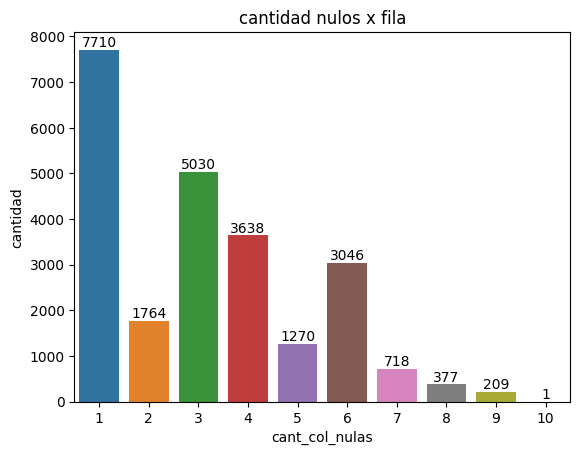

In [ ]:
# ax = sns.barplot(x=nulos_filas(data_hl2).cant_col_nulas, y=nulos_filas(data_hl2).cantidad)
# for i in ax.containers:
#     ax.bar_label(i,)
# plt.title("cantidad nulos x fila")
# plt.show()

ver_nulos_x_fila(data_hl)

Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

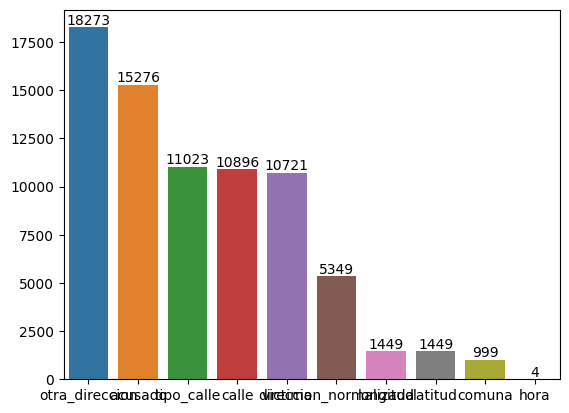

In [ ]:
ver_nulos_x_columna(data_hl)

Columna <code>otra_direccion</code>

In [ ]:
longitude= -58.421738
latitude = -34.581182
zoom_level = 15

url = f'https://www.google.com/maps/@{latitude},{longitude},{zoom_level}z?hl=es&markers={latitude},{longitude}'
url

'https://www.google.com/maps/@-34.581182,-58.421738,15z?hl=es&markers=-34.581182,-58.421738'

In [ ]:
data_hl.query("otra_direccion.isna() and data_geo")

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,otra_direccion,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado
id,,,,,,,,,,,,,,,,,,
LC-2019-0687058,1,2019-01-11 00:00:00,09:20:00,"PAZ, GRAL. AV. y ACHA, MARIANO, GRAL.",NaN,NaN,NaN,"PAZ, GRAL. AV.",0,"ACHA, MARIANO, GRAL.",NaN,NaN,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO
LC-2019-0688515,1,2019-01-11 00:00:00,16:58:00,DEL LIBERTADOR AV. 100,NaN,NaN,NaN,DEL LIBERTADOR AV.,100,,NaN,NaN,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO
LC-2019-0757409,1,2019-01-12 00:00:00,06:45:00,TRONADOR y GIRIBONE,NaN,NaN,NaN,TRONADOR,0,GIRIBONE,NaN,NaN,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO
LC-2019-0025021,1,2019-01-13 00:00:00,02:20:00,PASEO COLON AV. y MEXICO,NaN,NaN,NaN,PASEO COLON AV.,0,MEXICO,NaN,NaN,NaN,NaN,SD-SD,GRAVE,True,MOTO
LC-2019-0033624,1,2019-01-17 00:00:00,02:45:00,"LACROZE, FEDERICO y CAMPOS, LUIS M. AV.",NaN,NaN,NaN,"LACROZE, FEDERICO",0,"CAMPOS, LUIS M. AV.",NaN,NaN,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0652812,1,2021-12-31 00:00:00,18:05:00,VIEL 276,6,CALLE,NaN,VIEL,276,,-58.432885960226,-34.619702288565,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO
LC-2021-0652849,1,2021-12-31 00:00:00,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",0,GUAMINI,-58.513477158887,-34.659713573880,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO
LC-2021-0652865,2,2021-12-31 00:00:00,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",4436,,-58.488326609395,-34.641753304864,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO


Columna <code>Gravedad</code>

In [ ]:
data_hl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23763 entries, LC-2019-0000179 to LC-2020-0244615
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   n_victimas             23763 non-null  int64 
 1   fecha                  23763 non-null  object
 2   hora                   23759 non-null  object
 3   direccion_normalizada  18414 non-null  object
 4   comuna                 22764 non-null  object
 5   tipo_calle             12740 non-null  object
 6   otra_direccion         5490 non-null   object
 7   calle                  12867 non-null  object
 8   altura                 23763 non-null  object
 9   cruce                  23763 non-null  object
 10  longitud               22314 non-null  object
 11  latitud                22314 non-null  object
 12  victima                13042 non-null  object
 13  acusado                8487 non-null   object
 14  participantes          23763 non-null  object
 15  

In [ ]:
data_hl.cruce

id
LC-2019-0000179           
LC-2019-0000053           
LC-2019-0000063           
LC-2019-0000079           
LC-2019-0000082           
                    ...   
LC-2021-0652849    GUAMINI
LC-2021-0652865           
LC-2021-0652907           
LC-2021-0652921     MORENO
LC-2020-0244615           
Name: cruce, Length: 23763, dtype: object

In [ ]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hl.cruce = data_hl.cruce.fillna('NA')

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

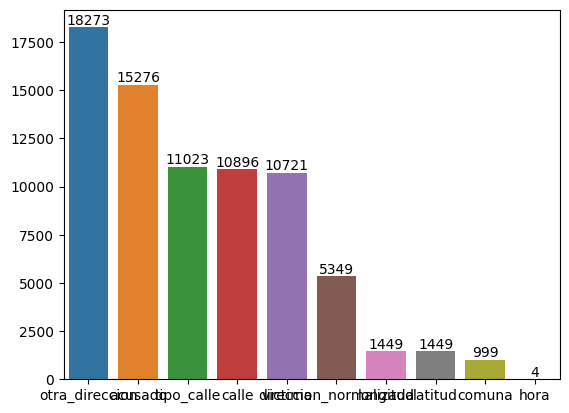

In [ ]:
nulos_columnas = data_hl.isna().sum()[data_hl.isna().sum() > 0].sort_values(ascending=False)

if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [ ]:
data_hl.query('otra_direccion.notna() and calle.isna()').loc['LC-2019-0000179'].otra_direccion

'Obligado Rafael, Av.Costanera 3300, Barrio: Palermo  , jurisdicción comisaria:  Vecinal 14C'

In [ ]:
pattern = r"Barrio:\s*([^,]+)"
data_hl['Barrio'] = data_hl['otra_direccion'].str.extract(pattern, expand=False)

In [ ]:
data_hl['Barrio'].value_counts()

Barrio
Palermo                                      381
Flores                                       267
Balvanera                                    256
Caballito                                    230
Recoleta                                     214
                                            ... 
Boedo Vía Pública                              1
No Especificada Villa 31                       1
Retiro MANZANA 14                              1
Belgrano PARADA DEL 68 DEL METROBUS            1
Constitucion INTERIOR COLECTIVO LINEA 23       1
Name: count, Length: 171, dtype: int64

In [ ]:
data_hl.drop('otra_direccion', axis=1, inplace=True)

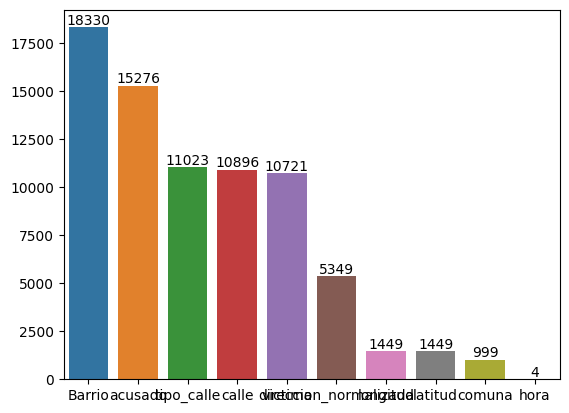

In [ ]:
ver_nulos_x_columna(data_hl)

In [ ]:
data_hl.loc[:,'direccion_normalizada'].fillna("SD", inplace=True)

C:\Users\javier\AppData\Local\Temp\ipykernel_23884\966001286.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Columna ```Dirección Normalizada```

In [ ]:
data_hl[data_hl.isna().loc[:, 'direccion_normalizada']].query('data_geo')

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,Barrio
id,,,,,,,,,,,,,,,,,,


In [ ]:
data_hl.fillna({'direccion_normalizada':'SD'}, inplace=True)

Columna ```Calle```

In [ ]:
data_hl.query('calle.isna() and data_geo == True')

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,Barrio
id,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,NaN,0,,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA,Palermo
LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,"Autopista Presidente Héctor J. Cámpora y Roca,...",8,NaN,NaN,0,,-58.44351,-34.669125,AUTO,NaN,AUTO-SD,NO_GRAVE,True,AUTO,Villa Soldati
LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,NaN,0,,-58.468335,-34.677556,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,Villa Lugano
LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,NaN,0,,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NO_GRAVE,True,MOTO,Parque Chacabuco interior Pasaje Roldan
LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,NaN,0,,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NO_GRAVE,True,TRANSPORTE_PUBLICO,Balvanera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0630499,1,2021-12-18 00:00:00,16:40:00,Corrientes Av. y Uriburu Jose E.,3,AVENIDA,NaN,0,,-58.398221919489,-34.604579570175,MOTO,NaN,MOTO-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0641694,1,2021-12-24 00:00:00,19:40:00,"Autopista 25 de Mayo km. 5,0 sentido CABA",NaN,NaN,NaN,0,,-58.4024529002351,-34.5704677450857,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0643354,1,2021-12-24 00:00:00,09:00:00,"Alvear, Marcelo T. De y Uriburu Jose E., Pres.",2,NaN,NaN,0,,-58.398875,-34.597048,NaN,MOTO,SD-MOTO,NO_GRAVE,True,MOTO,NaN


In [ ]:
mask_auto = data_hl[data_hl.loc[:,'direccion_normalizada'].apply(lambda st: st.startswith('Autopista '))].index

data_hl.loc[mask_auto, 'tipo_calle'] = 'AUTOPISTA'

data_hl.loc[mask_auto, 'direccion_normalizada'] = data_hl.loc[mask_auto, 'direccion_normalizada'][10:]

In [ ]:
def limpiar_auto(st):
    try:
        if st.startswith('Autopista '):
            return st[10:]
    except:
        return st

In [ ]:
data_hl.loc[:,'direccion_normalizada'].apply(limpiar_auto)

id
LC-2019-0000179    None
LC-2019-0000053     NaN
LC-2019-0000063    None
LC-2019-0000079    None
LC-2019-0000082    None
                   ... 
LC-2021-0652849    None
LC-2021-0652865    None
LC-2021-0652907    None
LC-2021-0652921    None
LC-2020-0244615    None
Name: direccion_normalizada, Length: 23763, dtype: object

In [ ]:
data_hl.loc[:,'direccion_normalizada']

id
LC-2019-0000179           Obligado Rafael, Av.Costanera 3300
LC-2019-0000053                                          NaN
LC-2019-0000063               Barros Pazos, Jose y Larraya 0
LC-2019-0000079      Torres Y Tenorio, Pres. y Riestra Av. 0
LC-2019-0000082    Corrientes Av. y Uriburu Jose E., Pres. 0
                                     ...                    
LC-2021-0652849         ALBERDI, JUAN BAUTISTA AV. y GUAMINI
LC-2021-0652865              ALBERDI, JUAN BAUTISTA AV. 4436
LC-2021-0652907    Barrio Padre Carlos Mugica (Villa 31 bis)
LC-2021-0652921                      LINIERS VIRREY y MORENO
LC-2020-0244615                                           SD
Name: direccion_normalizada, Length: 23763, dtype: object

In [ ]:
data_hl.query("data_geo and calle.isna() and tipo_calle.isna()")

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,Barrio
id,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,NaN,0,,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA,Palermo
LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,NaN,0,,-58.468335,-34.677556,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,Villa Lugano
LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,NaN,0,,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NO_GRAVE,True,MOTO,Parque Chacabuco interior Pasaje Roldan
LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,NaN,0,,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NO_GRAVE,True,TRANSPORTE_PUBLICO,Balvanera
LC-2019-0000136,2,2019-01-01 00:00:00,08:05:00,Cordoba Av. y Humboldt 0,15,NaN,NaN,0,,-58.439392,-34.588108,MOTO,NaN,MOTO-SD,NO_GRAVE,True,MOTO,Chacarita
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0628675,4,2021-12-17 00:00:00,13:00:00,SD,1,NaN,NaN,0,,-58.38145,-34.606663,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0629150,1,2021-12-17 00:00:00,16:00:00,SD,1,NaN,NaN,0,,-58.381749,-34.601891,TRANSPORTE PUBLICO,TRANSPORTE PUBLICO,TRANSPORTE PUBLICO-TRANSPORTE PUBLICO,NO_GRAVE,True,TRANSPORTE_PUBLICO,NaN
LC-2021-0643354,1,2021-12-24 00:00:00,09:00:00,"Alvear, Marcelo T. De y Uriburu Jose E., Pres.",2,NaN,NaN,0,,-58.398875,-34.597048,NaN,MOTO,SD-MOTO,NO_GRAVE,True,MOTO,NaN


In [ ]:
data_hl.query("direccion_normalizada.notna()")

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,calle,altura,cruce,longitud,latitud,victima,acusado,participantes,gravedad,data_geo,involucrado,Barrio
id,,,,,,,,,,,,,,,,,,
LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,"Obligado Rafael, Av.Costanera 3300",14,NaN,NaN,0,,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NO_GRAVE,True,CICLISTA,Palermo
LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,"Barros Pazos, Jose y Larraya 0",8,NaN,NaN,0,,-58.468335,-34.677556,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,Villa Lugano
LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,"Torres Y Tenorio, Pres. y Riestra Av. 0",7,NaN,NaN,0,,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NO_GRAVE,True,MOTO,Parque Chacabuco interior Pasaje Roldan
LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,"Corrientes Av. y Uriburu Jose E., Pres. 0",3,NaN,NaN,0,,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NO_GRAVE,True,TRANSPORTE_PUBLICO,Balvanera
LC-2019-0000136,2,2019-01-01 00:00:00,08:05:00,Cordoba Av. y Humboldt 0,15,NaN,NaN,0,,-58.439392,-34.588108,MOTO,NaN,MOTO-SD,NO_GRAVE,True,MOTO,Chacarita
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LC-2021-0652849,1,2021-12-31 00:00:00,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,"ALBERDI, JUAN BAUTISTA AV.",0,GUAMINI,-58.513477158887,-34.659713573880,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0652865,2,2021-12-31 00:00:00,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,"ALBERDI, JUAN BAUTISTA AV.",4436,,-58.488326609395,-34.641753304864,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN
LC-2021-0652907,1,2021-12-31 00:00:00,20:00:00,Barrio Padre Carlos Mugica (Villa 31 bis),1,NaN,NaN,0,,-58.382894,-34.583083,NaN,NaN,SD-SD,NO_GRAVE,True,MOTO,NaN


In [ ]:
data_hl[data_hl['direccion_normalizada'].isna()].loc[:, 'direccion_normalizada'] = 'SD'

C:\Users\javier\AppData\Local\Temp\ipykernel_23884\3261247246.py:1: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [ ]:
data_hl['direccion_normalizada'].fillna("SD", inplace=True)

In [ ]:
mask = data_hl['direccion_normalizada'].str.startswith('Rafael Obligado')
filtered_data = data_hl[mask]

In [ ]:
data_hl['geo_info'].value_counts()

KeyError: 'geo_info'

In [ ]:
# data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
# data_['pos y'].fillna(data_['pos y'].mean(), inplace=True)
# data_hm[data_hm['pos x'].isna()]
# data_hm.query("PARTICIPANTES == 'SD-SD'")
data_hm.query("COMUNA == 0")
# data_hm.COMUNA.isnull().sum()

Eliminada por falta de datos

In [ ]:
data_hm.drop(139, axis =0, inplace = True)

In [ ]:
contar_nulos(data_hm)

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [ ]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [ ]:
data_hm.COMUNA = data_hm.COMUNA.astype(str)

In [ ]:
data_hm.query("HORA == 'SD'")

In [ ]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')

In [ ]:
data_hm["HORA"] = data_hm["HORA"].astype(str)

In [ ]:
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)


In [ ]:
data_hm.query("HORA == 'SD'")

In [ ]:
# data_hm['COMUNA'] = data_hm['COMUNA'].replace('0', np.nan)

data_hm.COMUNA.isna().sum()

In [ ]:
# data_hm['FECHA_HORA'] = pd.to_datetime(data_hm['FECHA']) + data_hm['HORA'].apply(lambda x: pd.Timedelta(x))

In [ ]:
data_hm['HORA'] = data_hm['HORA'].astype(str)

In [ ]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))

# data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: x.split(' ').split('-').split(':'))


In [ ]:
data_hl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23785 entries, 0 to 23784
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             23785 non-null  int64  
 1   id                     23785 non-null  object 
 2   n_victimas             23785 non-null  int64  
 3   aaaa                   23785 non-null  int64  
 4   mm                     23785 non-null  int64  
 5   dd                     23785 non-null  int64  
 6   fecha                  23785 non-null  object 
 7   hora                   23785 non-null  object 
 8   franja_hora            23780 non-null  object 
 9   direccion_normalizada  23732 non-null  object 
 10  comuna                 23616 non-null  object 
 11  tipo_calle             23785 non-null  object 
 12  otra_direccion         23785 non-null  object 
 13  calle                  12867 non-null  object 
 14  altura                 12771 non-null  float64
 15  cr

In [ ]:
import re

pattern = r'[:\s;-]'

data_hl['FECHA_HORA'] = (data_hl['fecha'].astype(str) + ' ' + data_hl['hora'].astype(str)).apply(lambda x: re.split(pattern, x))
data_hl['FECHA_HORA'] = data_hl['FECHA_HORA'].apply(lambda x: list(map(int, x)))

def to_date(t):
    return datetime(* t)

data_hl['FECHA_HORA'] = data_hl['FECHA_HORA'].apply(to_date)

ValueError: invalid literal for int() with base 10: 'SD'

In [ ]:
data_hm['FECHA_HORA']

In [ ]:
# for i in data_hm['FECHA_HORA']:
#     list(map(int, i))

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

In [ ]:
from datetime import datetime
# # data_hm['FECHA_HORA'].apply(lambda t: datetime(*map(int,t)))

# for i, f in enumerate(data_hm['FECHA_HORA']):
#     for n in f:
#         n = int(n)
#     data_hm['FECHA_HORA'].loc[i] = f

def to_date(t):
    return datetime(* t)

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(to_date)

In [ ]:
data_hm['FECHA_HORA'] 

In [ ]:
# def to_timestamp(x):
#     year, month, day, hour, minute, second = map(int, x)
#     return datetime(year, month, day, hour, minute, second)

In [ ]:
# to_timestamp(data_hm['FECHA_HORA'][0])

In [ ]:
# data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)

In [ ]:
# for i in data_hm['FECHA_HORA'].index:
#     try:
#         to_timestamp(data_hm['FECHA_HORA'].loc[i])
#     except:
#         print(data_hm[['FECHA', 'HORA']].loc[i])


In [ ]:
# date_time_list = [int(x) for x in data_hm['FECHA_HORA'][0]]
# date_time_list

In [ ]:
# year, month, day, hour, minutes, seconds 

In [ ]:
data_hm.COMUNA.value_counts()

In [ ]:
type(data_hm['PARTICIPANTES'][0])

In [ ]:
# import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [ ]:
data_hm[data_hm['geo_info']]['pos x'].mean()

In [ ]:
data_hm[data_hm['geo_info']]['pos y'].mean()

In [ ]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]



In [ ]:
# data_.iloc[data_['Dirección Normalizada'].isna(), 13] = data_.iloc[data_['Dirección Normalizada'].isna(), 8].values

In [ ]:

data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

In [ ]:
showPie(data['VICTIMA'])

In [ ]:
showPie(data['ACUSADO'])

In [ ]:
showPie(data['PARTICIPANTES'])

In [ ]:
data.describe()

In [ ]:
# data['ACUSADO'].corr(data['VICTIMA'])

In [ ]:


comunas['barrios'] = comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
comunas.set_index('COMUNAS', drop=True, inplace=True)
comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
comunas.sort_index()

In [ ]:
pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas, left_on='comuna_id', right_on='COMUNAS')

In [ ]:
barrio_comuna = pd.DataFrame(comunas.barrios.explode())

In [ ]:
comunas

In [ ]:
# barrios.BARRIO.

In [ ]:
# import pandas as pd
# import researchpy as rp

# # Assuming df is your DataFrame containing the categorical variables
# # Let's say 'var1' and 'var2' are the columns representing the categorical variables

# data = data.reset_index()

# # Create a contingency table (cross-tabulation)
# contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# # Calculate Cramér's V
# cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
#                                 prop= 'cell', 
#                                 test= 'chi-square', 
#                                 expected_freqs= True, 
                                
#                                 correction= False)['results']

# cramers_v = cramers_v_result.loc[2, 'results']

# print("Cramér's V:", cramers_v)


In [ ]:
# %pip install ipywidgets

In [ ]:
pd.crosstab(data_hm['VICTIMA'], data_hm['ACUSADO'])


In [ ]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'NA'

In [ ]:
data_hm['ES_CRUCE'].value_counts()

In [ ]:
data_hm['Cruce'].fillna('NA', inplace=True)

In [ ]:
pd.crosstab(data_hm['PARTICIPANTES'], data_hm['ES_CRUCE']).sum()

In [ ]:
data_hm = data_hm.set_index(data_hm['ID']).drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [ ]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

# plt.plot(data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum())

In [ ]:
data_hm

In [ ]:
data_hm['comuna'][data_hm['comuna'].isnull()]

In [ ]:
data_hm['comuna'] = data_hm['comuna'].apply(lambda x: int(x))

In [ ]:
data_hm

In [ ]:
import matplotlib.pyplot as plt

# Assuming data_hm['fecha_hora'] is already a datetime column in data_hm

# Group by day name and hour, then sum 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum()

# Plot the result
grouped_data.plot(kind='line', figsize=(10, 6))
plt.xlabel('Day of Week, Hour of Day')
plt.ylabel('Total Victims')
plt.title('Total Victims by Day of Week and Hour')
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hour_of_Day', y='n_victimas', color='Day_of_Week', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Day_of_Week': 'Day of Week', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Iterate over unique days and create a separate bar plot for each day
for day in grouped_data['Day_of_Week'].unique():
    # Filter data for the current day
    day_data = grouped_data[grouped_data['Day_of_Week'] == day]
    
    # Create a bar plot for the current day
    fig = px.bar(day_data, x='Hour_of_Day', y='n_victimas', 
                 title=f'Total Number of Victims by Hour on {day}',
                 labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'})
    
    # Show the plot
    fig.show()


In [ ]:
data_hm['es_cruce'] = data_hm['es_cruce'].map({False:'Calle', True:'Esquina'})

In [ ]:
import plotly.express as px

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a pie chart using Plotly Express
fig = px.pie(grouped_data, values='n_victimas', names='es_cruce', 
             title='Proportion of Victims by Crossing Status')

# Show the plot
fig.show()

In [ ]:
data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()['es_cruce'].map({False:"Calle", True:"Esquina"})

In [ ]:
import pandas as pd

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a mapping dictionary
mapping = {False: "Calle", True: "Esquina"}

# Map boolean values to corresponding labels
grouped_data['es_cruce'] = grouped_data['es_cruce'].map(mapping)

# Show the result
print(grouped_data)

In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                 data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Año', y='n_victimas', color='Mes',
             title='Total Number of Victims by Day of Year and Month',)
            #  labels={'Año': 'Day of Week', 'n_victimas': 'Total Victims'},
            #  category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and month, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Total Number of Victims by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Victims')

# Show the plot
plt.show()


In [ ]:
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

grouped_data

In [ ]:
data_hm.groupby(data_hm['fecha_hora'].dt.to_period('M'))['n_victimas'].sum()

In [ ]:
data_hm['fecha_hora'].dt.to_period('M')

In [ ]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = data_hm.groupby(data_hm['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total Number of Victims Over Time',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()


In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx')

In [ ]:
data_hm.pos_y.mean()

In [ ]:
import folium
from branca.colormap import LinearColormap

# Assuming data contains latitude, longitude, and the value you want to use for color
# Replace 'value_column' with the actual name of the column in your DataFrame
value_column = 'comuna'

data_hm[value_column] = pd.to_numeric(data_hm[value_column], errors='coerce')

data_hm = data_hm.dropna()
data_hm = data_hm.rename({'pos_x': 'lon',  'pos_y': 'lat'}, axis=1)

# Define the minimum and maximum values for the color scale
min_value = data_hm[value_column].astype(float).min()
max_value = data_hm[value_column].astype(float).max()

# Create a color gradient
colormap = LinearColormap(['blue', 'yellow', 'red'], vmin=min_value, vmax=max_value)

# Create a Folium Map
map = folium.Map()

# Iterate over DataFrame rows
for i, row in data_hm.iterrows():
    # Get latitude, longitude, and value
    lat = row['lat']
    lon = row['lon']
    value = row[value_column]
    
    # Get marker color based on the value
    color = colormap(value)
    
    # Create marker with the specified color
    folium.Marker(location=(lat, lon), icon=folium.Icon(color=color)).add_to(map)

# Display the map
# map

In [ ]:
import csv

data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

In [ ]:
data = pd.read_csv('data/generated/data_hm.csv', sep=';', encoding='utf-8')

In [ ]:
data.iloc[136]

In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx', engine='openpyxl')

In [ ]:
data_hm.info()

In [ ]:
data_dias = data_hm.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias})

In [ ]:
data_dias = data.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

In [ ]:
data_dias = data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias},
             orientation='h')

fig.show()

In [ ]:
data.query('fecha_hora.dt.month == 12 and fecha_hora.dt.year == 2020').n_victimas.sum()

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

datos = data.groupby([data['fecha_hora'].dt.year, data['fecha_hora'].dt.month//6 + 1, data['fecha_hora'].dt.month])['n_victimas'].sum()

datos = datos.rename_axis(['Year', 'Semester', 'Month'])

datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Month' as a string
datos['date'] = datos['Year'].astype(str) + '-' + datos['Month'].astype(str).str.zfill(2)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Month and Year',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'},
             color='n_victimas')

# Show the plot
fig.show()

# datos.head(50)

In [ ]:
datos = data.groupby([data['fecha_hora'].dt.year, (data['fecha_hora'].dt.month - 1) // 6 + 1])['n_victimas'].sum()

# Rename the MultiIndex
datos = datos.rename_axis(['Year', 'Semester'])

# Reset the index
datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Semester' as a string
datos['date'] = datos['Year'].astype(str) + '-Semester ' + datos['Semester'].astype(str)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Year and Semester',
             color='n_victimas',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()

In [ ]:
data_hm

# EDA

In [ ]:
showPiePx(data_hm.n_victimas)

In [ ]:

# sns.catplot(x="tipo_de_calle", data = data_hm['tipo_de_calle', 'n_victimas'].groupby("tipo_de_calle").sum(), kind='box')

In [ ]:
showPiePx(data_hm.tipo_de_calle)


In [ ]:
data_hm.info()

In [ ]:
showPiePx(data_hm.es_cruce)

In [ ]:
showPiePx(data_hm.comuna)

In [ ]:
showPiePx(data_hm.participantes)

In [ ]:
showPiePx(data_hm.victima)

In [ ]:
showPiePx(data_hm.acusado)

In [ ]:
# pd.concat(data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'], data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'], axis=1)

In [ ]:
import pandas as pd

autopista_counts = data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']
avenida_counts = data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']

concatenated_counts = pd.concat([autopista_counts, avenida_counts], axis=1)


In [ ]:
import pandas as pd

# Calculate total occurrences for each type of street
total_autopista = data_hm.query("tipo_de_calle == 'AUTOPISTA'")['n_victimas'].count()
total_avenida = data_hm.query("tipo_de_calle == 'AVENIDA'")['n_victimas'].count()

# Calculate frequencies
autopista_counts = data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'] / total_autopista
autopista_counts.name = 'AUTOPISTA Frequency'

avenida_counts = data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'] / total_avenida
avenida_counts.name = 'AVENIDA Frequency'

# Concatenate into a DataFrame
concatenated_frequencies = pd.concat([autopista_counts, avenida_counts], axis=1)


In [ ]:
data_hm.tipo_de_calle.value_counts()

In [ ]:
pd.DataFrame([data_hm.query(f"tipo_de_calle == '{st}'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'].rename(f"{st}") for st in data_hm.tipo_de_calle.unique()]).T

In [ ]:
((data_hm.fecha_hora.dt.month-1) // 6).value_counts()